## 1. importing packages

In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import datetime as dt
import pandas_datareader as web
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import matplotlib.ticker as ticker
import itertools

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, Input, Activation, concatenate
from tensorflow.keras.callbacks import History, EarlyStopping
from tensorflow.keras import optimizers

import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


## 2. overall configurations

In [2]:
%matplotlib inline


tqdm.pandas()
sns.set(style='whitegrid',palette='muted')
rcParams['figure.figsize'] = 14, 10

## 3. Getting the Data

In [3]:
import yfinance as yf
ticket = yf.Ticker('BOVA11.SA')
start = dt.datetime(2009, 1, 2) # First register data
end = dt.datetime(dt.datetime.now().year,dt.datetime.now().month,dt.datetime.now().day - 1)

bova11 = ticket.history(interval= '1d', start = start, end = end).reset_index()
bova11
bova11_copy = bova11.copy()

In [4]:
len(bova11)

3497

## 4. Pre-processing

Adjust the columns name and type

In [5]:
bova11.columns = bova11.columns.str.lower()

In [6]:
bova11.date = pd.to_datetime(bova11.date)

In [7]:
bova11.isna().sum()

date            0
open            0
high            0
low             0
close           0
volume          0
dividends       0
stock splits    0
dtype: int64

Removing rows with volume 0

In [8]:
bova11 = bova11.loc[(bova11.volume != 0)].reset_index()
bova11.drop(columns='index', axis = 1, inplace = True)
bova11

,date,open,high,low,close,volume,dividends,stock splits
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0
...,...,...,...,...,...,...,...,...
3399,2023-01-27 00:00:00-03:00,110.279999,110.290001,108.339996,108.400002,5294651,0,0
3400,2023-01-30 00:00:00-03:00,109.010002,109.320000,108.129997,108.699997,2905618,0,0
3401,2023-01-31 00:00:00-03:00,108.709999,109.959999,108.709999,109.839996,5733562,0,0
3402,2023-02-01 00:00:00-03:00,109.489998,109.860001,107.059998,108.400002,10380157,0,0


Sorting the data by date

In [9]:
bova11 = bova11.sort_values(by='date').reset_index(drop=True)

Adding a column with the previous close value

In [10]:
bova11["prev_close"] = bova11.shift(1)["close"]

In [11]:
bova11.head()

,date,open,high,low,close,volume,dividends,stock splits,prev_close
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0,NaN
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0,40.320000
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0,42.000000
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0,42.320000
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0,40.639999


Adding the close difference between dates

In [12]:
bova11["close_change"]= bova11.progress_apply(
    lambda row: 0 if np.isnan(row.prev_close) else row.close - row.prev_close,
    axis = 1
)

100%|██████████| 3404/3404 [00:00<00:00, 6330.76it/s]


In [13]:
bova11.head()

,date,open,high,low,close,volume,dividends,stock splits,prev_close,close_change
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0,NaN,0.000000
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0,40.320000,1.680000
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0,42.000000,0.320000
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0,42.320000,-1.680000
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0,40.639999,1.560001


Checking the dataseries over time

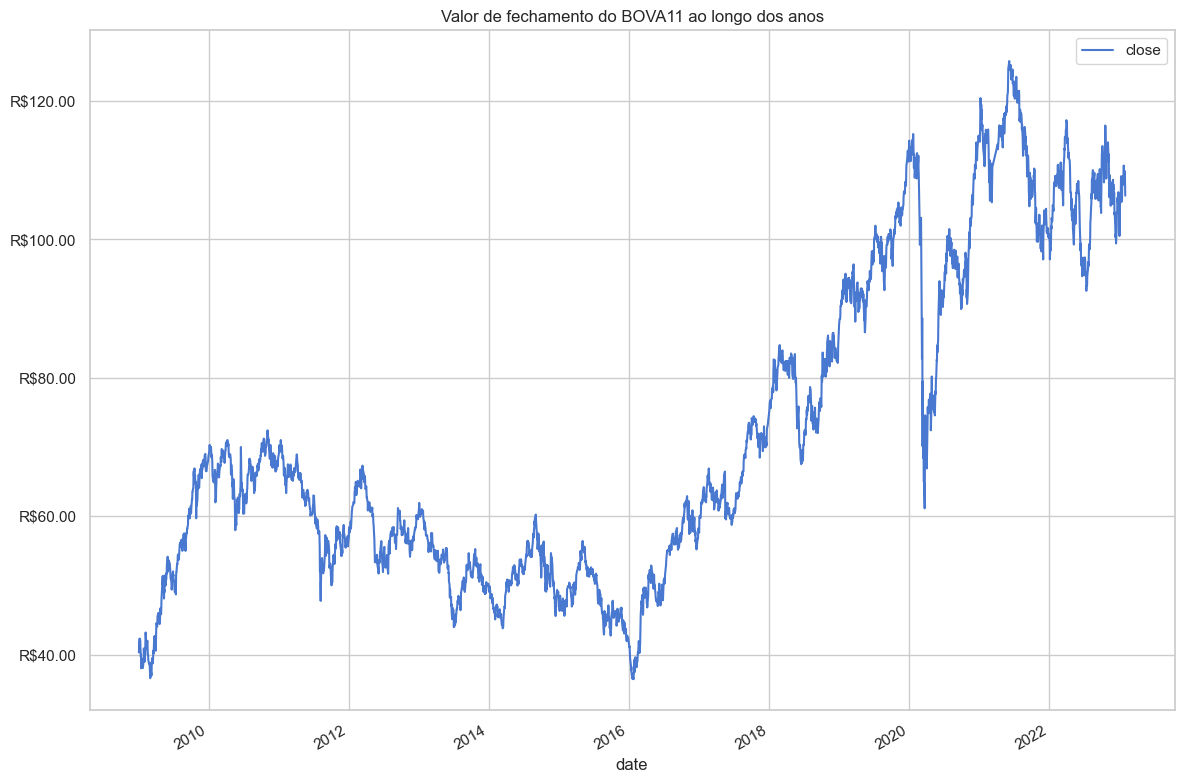

In [14]:
daily_closing = bova11[['date','close']]
daily_closing = daily_closing.set_index('date')
ax = daily_closing.plot()
plt.title('Valor de fechamento do BOVA11 ao longo dos anos')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("R${x:,.2f}"))

#### Feature Engineering
Add auxiliar columns that can improve our model, like moving averages,standard deviation, techinical indicators and others
Let's add:
- Moving_average for 3, 10, 30 and 60 days
- Standard deviation for 7, 30 and 60 days
- Bollinger limits for Upper and lowers 3, 30 and 60
- Add RSI indicator

In [15]:
# Adding move Averages columns
bova11['ma_3d'] = bova11['close'].rolling(3, center = True, min_periods=1).mean()
bova11['ma_10d'] = bova11['close'].rolling(10, center = True,min_periods=1).mean()
bova11['ma_30d'] = bova11['close'].rolling(30, center=True, min_periods=1).mean()
bova11['ma_60d'] = bova11['close'].rolling(60, center = True, min_periods = 1).mean()

In [16]:
# Adding standard deviation columns
bova11['std_7'] = bova11['close'].rolling(7, center = True, min_periods = 1).std()
bova11['std_30'] = bova11['close'].rolling(30, center = True, min_periods = 1).std()
bova11['std_60'] = bova11['close'].rolling(60, center = True, min_periods = 1).std()

In [17]:
# Adding the bollinger bands
bova11['upper3'] = bova11['ma_3d'] + 2*bova11['close'].rolling(3, center = True, min_periods = 1).std()
bova11['lower3'] = bova11['ma_3d'] - 2*bova11['close'].rolling(3, center = True, min_periods = 1).std()

bova11['upper30'] = bova11['ma_30d'] + 2*bova11['std_30']
bova11['lower30'] = bova11['ma_30d'] - 2*bova11['std_30']

bova11['upper60'] = bova11['ma_60d'] + 2*bova11['std_60']
bova11['lower60'] = bova11['ma_60d'] - 2*bova11['std_60']

# Adding tecnical indicator RSI
bova11['RSI'] = ta.rsi(bova11['close'], length = 15)

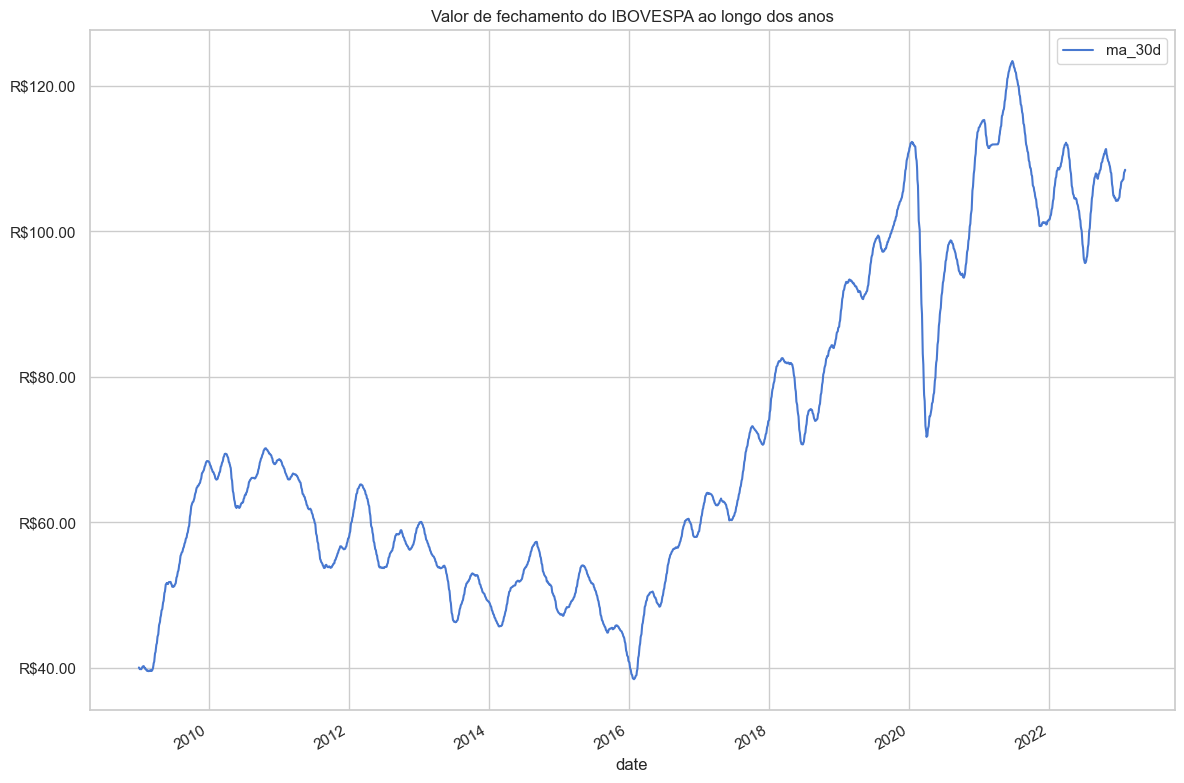

In [18]:
moving_avg = bova11[['date','ma_30d']]
moving_avg = moving_avg.set_index('date')
ax = moving_avg.plot()
plt.title('Valor de fechamento do IBOVESPA ao longo dos anos')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("R${x:,.2f}"))

Select the features and the predict columns

In [19]:
bova11.drop(['date', 'volume', 'dividends', 'stock splits', 'prev_close'],
            axis = 1,
           inplace = True)


In [20]:
bova11

,open,high,low,close,close_change,ma_3d,ma_10d,ma_30d,ma_60d,std_7,std_30,std_60,upper3,lower3,upper30,lower30,upper60,lower60,RSI
0,38.279999,40.320000,37.939999,40.320000,0.000000,41.160000,41.496000,40.072667,40.216334,0.987387,1.459904,1.394817,43.535879,38.784121,42.992476,37.152858,43.005967,37.426700,NaN
1,40.200001,42.000000,39.700001,42.000000,1.680000,41.546666,41.580000,39.948125,40.269033,0.941319,1.495795,1.402411,43.695279,39.398054,42.939715,36.956536,43.073854,37.464211,NaN
2,42.060001,42.320000,41.549999,42.320000,0.320000,41.653333,41.311429,39.892353,40.322813,0.866718,1.466439,1.412751,43.437411,39.869255,42.825231,36.959475,43.148315,37.497311,NaN
3,41.750000,41.770000,40.450001,40.639999,-1.680000,41.720000,41.147500,39.842223,40.313031,1.063445,1.438465,1.391637,43.594461,39.845539,42.719153,36.965292,43.096304,37.529757,NaN
4,40.150002,42.200001,40.150002,42.200001,1.560001,41.613333,40.801111,39.897895,40.303530,1.118613,1.418844,1.371508,43.311019,39.915647,42.735582,37.060208,43.046547,37.560513,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3399,110.279999,110.290001,108.339996,108.400002,-2.019997,109.173332,108.849000,108.097000,106.076000,0.938720,1.546823,3.006460,111.353361,106.993303,111.190647,105.003353,112.088921,100.063079,53.755845
3400,109.010002,109.320000,108.129997,108.699997,0.299995,108.979998,108.893333,108.233684,106.240000,1.501802,1.459856,2.888394,110.499468,107.460529,111.153396,105.313973,112.016789,100.463212,54.525609
3401,108.709999,109.959999,108.709999,109.839996,1.139999,108.979998,109.017500,108.393889,106.447273,1.427915,1.319171,2.664053,110.499468,107.460529,111.032230,105.755548,111.775380,101.119166,57.411912
3402,109.489998,109.860001,107.059998,108.400002,-1.439995,108.180000,108.958571,108.465294,106.605938,1.279419,1.323428,2.543337,111.740443,104.619557,111.112150,105.818438,111.692613,101.519263,52.870335


In [21]:
bova11['target'] = bova11.close - bova11.open
#bova11['targetClass'] = [1 if bova11.target[i] > 0 else 0 for i in range(len(bova11))]
bova11['targetNextClose'] = bova11['close'].shift(-1)

In [22]:
bova11

,open,high,low,close,close_change,ma_3d,ma_10d,ma_30d,ma_60d,std_7,...,std_60,upper3,lower3,upper30,lower30,upper60,lower60,RSI,target,targetNextClose
0,38.279999,40.320000,37.939999,40.320000,0.000000,41.160000,41.496000,40.072667,40.216334,0.987387,...,1.394817,43.535879,38.784121,42.992476,37.152858,43.005967,37.426700,NaN,2.040001,42.000000
1,40.200001,42.000000,39.700001,42.000000,1.680000,41.546666,41.580000,39.948125,40.269033,0.941319,...,1.402411,43.695279,39.398054,42.939715,36.956536,43.073854,37.464211,NaN,1.799999,42.320000
2,42.060001,42.320000,41.549999,42.320000,0.320000,41.653333,41.311429,39.892353,40.322813,0.866718,...,1.412751,43.437411,39.869255,42.825231,36.959475,43.148315,37.497311,NaN,0.259998,40.639999
3,41.750000,41.770000,40.450001,40.639999,-1.680000,41.720000,41.147500,39.842223,40.313031,1.063445,...,1.391637,43.594461,39.845539,42.719153,36.965292,43.096304,37.529757,NaN,-1.110001,42.200001
4,40.150002,42.200001,40.150002,42.200001,1.560001,41.613333,40.801111,39.897895,40.303530,1.118613,...,1.371508,43.311019,39.915647,42.735582,37.060208,43.046547,37.560513,NaN,2.049999,42.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3399,110.279999,110.290001,108.339996,108.400002,-2.019997,109.173332,108.849000,108.097000,106.076000,0.938720,...,3.006460,111.353361,106.993303,111.190647,105.003353,112.088921,100.063079,53.755845,-1.879997,108.699997
3400,109.010002,109.320000,108.129997,108.699997,0.299995,108.979998,108.893333,108.233684,106.240000,1.501802,...,2.888394,110.499468,107.460529,111.153396,105.313973,112.016789,100.463212,54.525609,-0.310005,109.839996
3401,108.709999,109.959999,108.709999,109.839996,1.139999,108.979998,109.017500,108.393889,106.447273,1.427915,...,2.664053,110.499468,107.460529,111.032230,105.755548,111.775380,101.119166,57.411912,1.129997,108.400002
3402,109.489998,109.860001,107.059998,108.400002,-1.439995,108.180000,108.958571,108.465294,106.605938,1.279419,...,2.543337,111.740443,104.619557,111.112150,105.818438,111.692613,101.519263,52.870335,-1.089996,106.300003


In [23]:
bova11.dropna(inplace = True)

In [24]:
scaler = MinMaxScaler(feature_range = (-1, 1))
bova11_scaled = scaler.fit_transform(bova11)
print(bova11_scaled)

[[-0.41052802 -0.95937954 -0.97594966 ... -0.34158244 -0.812735
  -0.94288915]
 [-0.39380423 -0.93549828 -0.95100022 ... -0.1145866  -0.81635782
  -0.94311308]
 [-0.38663696 -0.9468809  -0.94178467 ... -0.11645738 -0.82917641
  -0.90033593]
 ...
 [ 0.73624277  0.62280992  0.62733194 ...  0.1831316  -0.85119142
   0.64367293]
 [ 0.73146451  0.63709403  0.64036862 ...  0.26982232 -0.81106316
   0.6114222 ]
 [ 0.74388784  0.63486217  0.6032816  ...  0.13341511 -0.87292727
   0.56438976]]


Select the features and prediction target columns

### 6. Calculating Error metrics

In [25]:
def MAPE(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    MAPE = np.nanmean(np.abs((actual - pred) / actual)) * 100
    return MAPE

def MAE(actual, pred):
    MAE = mean_absolute_error(actual, pred)
    return MAE

def RMSE(actual, pred):
    RMSE = mean_squared_error(actual, pred, squared = False)
    return RMSE

In [26]:
n_neurons = 128
n_batch_size = 32
dropout = 0.2
pass_days = 100

In [27]:
backcandles = pass_days
X = []
for j in range(19): # range is the number of feature columns you will use
    X.append([])
    for k in range(backcandles, bova11_scaled.shape[0]):
        X[j].append(bova11_scaled[k-backcandles:k, j])

#move axis from 0 to position 2
X = np.moveaxis(X, [0], [2])

X, yi = np.array(X), np.array(bova11_scaled[backcandles:, -1]) # Chosing the last column as the pred. target
y = np.reshape(yi, (len(yi), 1))

splitlimit = int(len(X) * 0.9)
x_train, x_test = X[:splitlimit], X[splitlimit+1:]
y_train, y_test = y[:splitlimit], y[splitlimit+1:]

In [28]:
model = Sequential()
model.add(GRU(units = n_neurons, 
               return_sequences = True,
               input_shape = (x_train.shape[1],
                             x_train.shape[2])))
model.add(Dropout(dropout))

model.add(GRU(units = n_neurons, return_sequences = False))
model.add(Dropout(dropout))
model.add(Dense(units = 1, activation = 'linear'))
model.compile(optimizer = 'adam', loss = 'mse')

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 7)

file_path = 'best_model.h5'

mc = ModelCheckpoint(file_path, monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only = True)

model.fit(x_train, y_train, 
          validation_split = 0.1, 
          epochs = 50, batch_size = n_batch_size,
         callbacks = [es, mc], verbose = 0)


Epoch 1: val_loss improved from inf to 0.00275, saving model to best_model.h5

Epoch 2: val_loss improved from 0.00275 to 0.00163, saving model to best_model.h5

Epoch 3: val_loss did not improve from 0.00163

Epoch 4: val_loss did not improve from 0.00163

Epoch 5: val_loss did not improve from 0.00163

Epoch 6: val_loss improved from 0.00163 to 0.00125, saving model to best_model.h5

Epoch 7: val_loss did not improve from 0.00125

Epoch 8: val_loss did not improve from 0.00125

Epoch 9: val_loss did not improve from 0.00125

Epoch 10: val_loss did not improve from 0.00125

Epoch 11: val_loss improved from 0.00125 to 0.00120, saving model to best_model.h5

Epoch 12: val_loss did not improve from 0.00120

Epoch 13: val_loss did not improve from 0.00120

Epoch 14: val_loss did not improve from 0.00120

Epoch 15: val_loss improved from 0.00120 to 0.00116, saving model to best_model.h5

Epoch 16: val_loss did not improve from 0.00116

Epoch 17: val_loss did not improve from 0.00116

Epoc

11/11 [==============================] - 3s 68ms/step


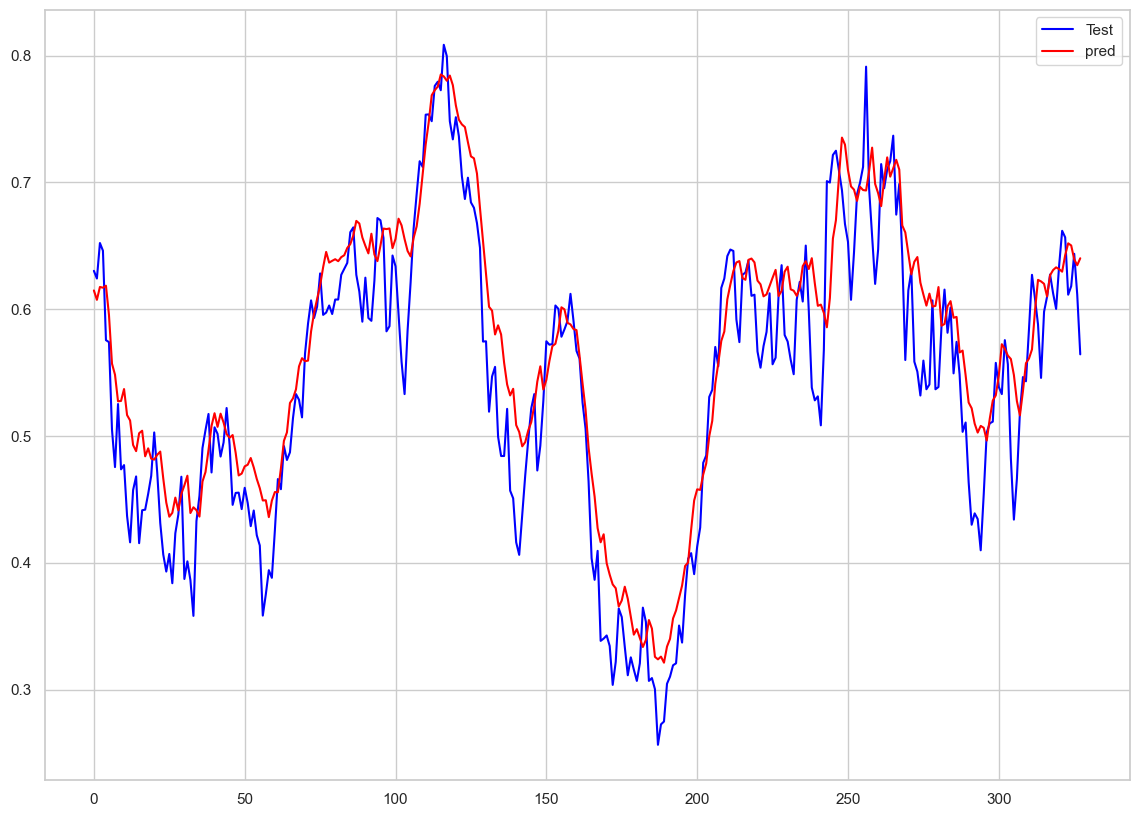

In [29]:
y_pred = model.predict(x_test)

plt.plot(y_test, color = 'blue', label = 'Test')
plt.plot(y_pred, color = 'red', label = 'pred')
plt.legend()
plt.show()

In [30]:
MAE(y_test,y_pred), MAPE(y_test, y_pred), RMSE(y_test, y_pred)

(0.037475263119134905, 7.636173490036629, 0.046506218964879054)

### 2. try a different method:
- Separete the last 90 values from the bova_11 values
- Format them with the same features as the prediction
- Do the predict on the next value
- invert the transformation to get the original values
- Recreate the dataframe with the same values and the prediction value
- Complete all the feature columns for the next input to predict
- make the next prediction
- put it into a for loop for n days
- predict for 1,5,30 and 90 days
- calculate the error metrics from all the predictions

In [31]:
def feature_calc(df):
    # Adding close change
    df["prev_close"] = df.shift(1)["close"]
    df["close_change"]= df.progress_apply(
        lambda row: 0 if np.isnan(row.prev_close) else row.close - row.prev_close,
        axis = 1
    )
    # Adding move Averages columns
    df['ma_3d'] = df['close'].rolling(3, center = True, min_periods=1).mean()
    df['ma_10d'] = df['close'].rolling(10, center = True,min_periods=1).mean()
    df['ma_30d'] = df['close'].rolling(30, center=True, min_periods=1).mean()
    df['ma_60d'] = df['close'].rolling(60, center = True, min_periods = 1).mean()
    # Adding standard deviation columns
    df['std_7'] = df['close'].rolling(7, center = True, min_periods = 1).std()
    df['std_30'] = df['close'].rolling(30, center = True, min_periods = 1).std()
    df['std_60'] = df['close'].rolling(60, center = True, min_periods = 1).std()
    # Adding the bollinger bands
    df['upper3'] = df['ma_3d'] + 2*df['close'].rolling(3, center = True, min_periods = 1).std()
    df['lower3'] = df['ma_3d'] - 2*df['close'].rolling(3, center = True, min_periods = 1).std()
    df['upper30'] = df['ma_30d'] + 2*df['std_30']
    df['lower30'] = df['ma_30d'] - 2*df['std_30']
    df['upper60'] = df['ma_60d'] + 2*df['std_60']
    df['lower60'] = df['ma_60d'] - 2*df['std_60']
    # Adding tecnical indicator RSI
    df['RSI'] = ta.rsi(df['close'], length = 15)
    df['target'] = df.close - df.open
    df['targetNextClose'] = df['close'].shift(-1)
    
    return df

In [32]:
def predict(df, days):
    # copy the dataframe to edit
    df_ = df.copy()
    
    for i in reversed(range(days+1)):
        if days > 0:
            # scale the features for the model prediction
            scaler = MinMaxScaler(feature_range = (-1, 1))
            df_scaled = scaler.fit_transform(df_)

            backcandles = pass_days #Defined by hyperparameters testing
            X = []
            for j in range(19): # range is the number of feature columns you will use
                X.append([])
                for k in range(backcandles, df_scaled.shape[0]):
                    X[j].append(df_scaled[k-backcandles:k, j])

            #move axis from 0 to position 2
            X = np.moveaxis(X, [0], [2])

            X, yi = np.array(X), np.array(df_scaled[backcandles:, -1]) # Chosing the last column as the pred. target
            y = np.reshape(yi, (len(yi), 1))

            splitlimit = int(len(X) * 0.9)
            x_test = X[splitlimit+1:] # take the last 10% of the original database

            if days > 1:
                x_test = x_test[-days:-(days-1)] 
            else:
                x_test = x_test[-days:]
            
            y_pred = model.predict(x_test) # make the prediction on the day to replace
            #print(y_pred)
            #print(df_scaled[-days][3])
            df_scaled[-days][3] = y_pred[0]
            
            predict_value = scaler.inverse_transform(df_scaled)[-days][3]
            #print(predict_value)
            df_.loc[(len(df_) - days) : (len(df_) - days), 'close'] = predict_value
            #print(df_.loc[(len(df_) - days) : (len(df_) - days)].close)
            
            df_ = feature_calc(df_)
            #print(days)
            days = days -1
    
    return df_

In [33]:
bova11.reset_index(drop = True, inplace = True)

In [34]:
pred_1 = predict(bova11, 1)

1/1 [==============================] - 0s 83ms/step


100%|██████████| 3388/3388 [00:00<00:00, 6960.87it/s]


In [35]:
pred_5 = predict (bova11, 5)

1/1 [==============================] - 0s 59ms/step


100%|██████████| 3388/3388 [00:00<00:00, 7000.05it/s]


1/1 [==============================] - 0s 64ms/step


100%|██████████| 3388/3388 [00:00<00:00, 7669.62it/s]


1/1 [==============================] - 0s 69ms/step


100%|██████████| 3388/3388 [00:00<00:00, 7583.76it/s]


1/1 [==============================] - 0s 63ms/step


100%|██████████| 3388/3388 [00:00<00:00, 6432.51it/s]


1/1 [==============================] - 0s 67ms/step


100%|██████████| 3388/3388 [00:00<00:00, 7600.75it/s]


In [36]:
pred_30 = predict(bova11, 30)

1/1 [==============================] - 0s 48ms/step


100%|██████████| 3388/3388 [00:00<00:00, 8560.44it/s] 


1/1 [==============================] - 0s 64ms/step


100%|██████████| 3388/3388 [00:00<00:00, 8208.10it/s]


1/1 [==============================] - 0s 49ms/step


100%|██████████| 3388/3388 [00:00<00:00, 6336.33it/s]


1/1 [==============================] - 0s 63ms/step


100%|██████████| 3388/3388 [00:00<00:00, 7353.44it/s]


1/1 [==============================] - 0s 51ms/step


100%|██████████| 3388/3388 [00:00<00:00, 7441.51it/s]


1/1 [==============================] - 0s 40ms/step


100%|██████████| 3388/3388 [00:00<00:00, 13559.73it/s]


1/1 [==============================] - 0s 44ms/step


100%|██████████| 3388/3388 [00:00<00:00, 6739.44it/s]


1/1 [==============================] - 0s 144ms/step


100%|██████████| 3388/3388 [00:00<00:00, 5674.62it/s]


1/1 [==============================] - 0s 69ms/step


100%|██████████| 3388/3388 [00:00<00:00, 6759.41it/s]


1/1 [==============================] - 0s 63ms/step


100%|██████████| 3388/3388 [00:00<00:00, 7533.19it/s]


1/1 [==============================] - 0s 60ms/step


100%|██████████| 3388/3388 [00:00<00:00, 6960.87it/s]


1/1 [==============================] - 0s 63ms/step


100%|██████████| 3388/3388 [00:00<00:00, 8453.41it/s]


1/1 [==============================] - 0s 55ms/step


100%|██████████| 3388/3388 [00:00<00:00, 10272.57it/s]


1/1 [==============================] - 0s 58ms/step


100%|██████████| 3388/3388 [00:00<00:00, 13452.15it/s]


1/1 [==============================] - 0s 53ms/step


100%|██████████| 3388/3388 [00:00<00:00, 13037.15it/s]


1/1 [==============================] - 0s 39ms/step


100%|██████████| 3388/3388 [00:00<00:00, 13950.27it/s]


1/1 [==============================] - 0s 49ms/step


100%|██████████| 3388/3388 [00:00<00:00, 11954.76it/s]


1/1 [==============================] - 0s 40ms/step


100%|██████████| 3388/3388 [00:00<00:00, 13724.55it/s]


1/1 [==============================] - 0s 40ms/step


100%|██████████| 3388/3388 [00:00<00:00, 10830.48it/s]


1/1 [==============================] - 0s 41ms/step


100%|██████████| 3388/3388 [00:00<00:00, 12602.05it/s]


1/1 [==============================] - 0s 40ms/step


100%|██████████| 3388/3388 [00:00<00:00, 10356.83it/s]


1/1 [==============================] - 0s 40ms/step


100%|██████████| 3388/3388 [00:00<00:00, 12372.10it/s]


1/1 [==============================] - 0s 40ms/step


100%|██████████| 3388/3388 [00:00<00:00, 10119.21it/s]


1/1 [==============================] - 0s 52ms/step


100%|██████████| 3388/3388 [00:00<00:00, 13139.27it/s]


1/1 [==============================] - 0s 41ms/step


100%|██████████| 3388/3388 [00:00<00:00, 10035.76it/s]


1/1 [==============================] - 0s 42ms/step


100%|██████████| 3388/3388 [00:00<00:00, 13836.52it/s]


1/1 [==============================] - 0s 58ms/step


100%|██████████| 3388/3388 [00:00<00:00, 10693.84it/s]


1/1 [==============================] - 0s 40ms/step


100%|██████████| 3388/3388 [00:00<00:00, 14008.07it/s]


1/1 [==============================] - 0s 57ms/step


100%|██████████| 3388/3388 [00:00<00:00, 12372.18it/s]


1/1 [==============================] - 0s 40ms/step


100%|██████████| 3388/3388 [00:00<00:00, 13724.46it/s]


In [37]:
pred_90 = predict(bova11, 90)

1/1 [==============================] - 0s 51ms/step


100%|██████████| 3388/3388 [00:00<00:00, 8619.15it/s]


1/1 [==============================] - 0s 61ms/step


100%|██████████| 3388/3388 [00:00<00:00, 7792.98it/s]


1/1 [==============================] - 0s 54ms/step


100%|██████████| 3388/3388 [00:00<00:00, 8188.28it/s]


1/1 [==============================] - 0s 51ms/step


100%|██████████| 3388/3388 [00:00<00:00, 8474.85it/s]


1/1 [==============================] - 0s 60ms/step


100%|██████████| 3388/3388 [00:00<00:00, 8975.07it/s]


1/1 [==============================] - 0s 61ms/step


100%|██████████| 3388/3388 [00:00<00:00, 8494.74it/s]


1/1 [==============================] - 0s 53ms/step


100%|██████████| 3388/3388 [00:00<00:00, 7970.13it/s]


1/1 [==============================] - 0s 39ms/step


100%|██████████| 3388/3388 [00:00<00:00, 14008.08it/s]


1/1 [==============================] - 0s 51ms/step


100%|██████████| 3388/3388 [00:00<00:00, 9390.42it/s]


1/1 [==============================] - 0s 46ms/step


100%|██████████| 3388/3388 [00:00<00:00, 13950.46it/s]


1/1 [==============================] - 0s 54ms/step


100%|██████████| 3388/3388 [00:00<00:00, 10241.49it/s]


1/1 [==============================] - 0s 44ms/step


100%|██████████| 3388/3388 [00:00<00:00, 12759.27it/s]


1/1 [==============================] - 0s 59ms/step


100%|██████████| 3388/3388 [00:00<00:00, 10192.15it/s]


1/1 [==============================] - 0s 63ms/step


100%|██████████| 3388/3388 [00:00<00:00, 9186.87it/s] 


1/1 [==============================] - 0s 42ms/step


100%|██████████| 3388/3388 [00:00<00:00, 13914.58it/s]


1/1 [==============================] - 0s 40ms/step


100%|██████████| 3388/3388 [00:00<00:00, 9685.56it/s]


1/1 [==============================] - 0s 40ms/step


100%|██████████| 3388/3388 [00:00<00:00, 14183.93it/s]


1/1 [==============================] - 0s 63ms/step


100%|██████████| 3388/3388 [00:00<00:00, 11413.92it/s]


1/1 [==============================] - 0s 43ms/step


100%|██████████| 3388/3388 [00:00<00:00, 11240.13it/s]


1/1 [==============================] - 0s 41ms/step


100%|██████████| 3388/3388 [00:00<00:00, 13559.71it/s]


1/1 [==============================] - 0s 40ms/step


100%|██████████| 3388/3388 [00:00<00:00, 9657.95it/s] 


1/1 [==============================] - 0s 41ms/step


100%|██████████| 3388/3388 [00:00<00:00, 13614.24it/s]


1/1 [==============================] - 0s 47ms/step


100%|██████████| 3388/3388 [00:00<00:00, 9481.92it/s] 


1/1 [==============================] - 0s 47ms/step


100%|██████████| 3388/3388 [00:00<00:00, 14066.22it/s]


1/1 [==============================] - 0s 40ms/step


100%|██████████| 3388/3388 [00:00<00:00, 10149.53it/s]


1/1 [==============================] - 0s 41ms/step


100%|██████████| 3388/3388 [00:00<00:00, 11234.13it/s]


1/1 [==============================] - 0s 74ms/step


100%|██████████| 3388/3388 [00:00<00:00, 8815.34it/s]


1/1 [==============================] - 0s 52ms/step


100%|██████████| 3388/3388 [00:00<00:00, 7792.97it/s]


1/1 [==============================] - 0s 50ms/step


100%|██████████| 3388/3388 [00:00<00:00, 8944.45it/s]


1/1 [==============================] - 0s 66ms/step


100%|██████████| 3388/3388 [00:00<00:00, 8517.44it/s]


1/1 [==============================] - 0s 73ms/step


100%|██████████| 3388/3388 [00:00<00:00, 9313.01it/s]


1/1 [==============================] - 0s 40ms/step


100%|██████████| 3388/3388 [00:00<00:00, 7218.00it/s]


1/1 [==============================] - 0s 45ms/step


100%|██████████| 3388/3388 [00:00<00:00, 12938.75it/s]


1/1 [==============================] - 0s 56ms/step


100%|██████████| 3388/3388 [00:00<00:00, 11811.59it/s]


1/1 [==============================] - 0s 48ms/step


100%|██████████| 3388/3388 [00:00<00:00, 14152.73it/s]


1/1 [==============================] - 0s 57ms/step


100%|██████████| 3388/3388 [00:00<00:00, 13780.25it/s]


1/1 [==============================] - 0s 39ms/step


100%|██████████| 3388/3388 [00:00<00:00, 14451.12it/s]


1/1 [==============================] - 0s 53ms/step


100%|██████████| 3388/3388 [00:00<00:00, 13780.23it/s]


1/1 [==============================] - 0s 41ms/step


100%|██████████| 3388/3388 [00:00<00:00, 14364.19it/s]


1/1 [==============================] - 0s 42ms/step


100%|██████████| 3388/3388 [00:00<00:00, 13559.80it/s]


1/1 [==============================] - 0s 40ms/step


100%|██████████| 3388/3388 [00:00<00:00, 14124.79it/s]


1/1 [==============================] - 0s 40ms/step


100%|██████████| 3388/3388 [00:00<00:00, 12696.31it/s]


1/1 [==============================] - 0s 39ms/step


100%|██████████| 3388/3388 [00:00<00:00, 14758.84it/s]


1/1 [==============================] - 0s 40ms/step


100%|██████████| 3388/3388 [00:00<00:00, 12792.23it/s]


1/1 [==============================] - 0s 41ms/step


100%|██████████| 3388/3388 [00:00<00:00, 14425.24it/s]


1/1 [==============================] - 0s 48ms/step


100%|██████████| 3388/3388 [00:00<00:00, 12649.10it/s]


1/1 [==============================] - 0s 41ms/step


100%|██████████| 3388/3388 [00:00<00:00, 12555.28it/s]


1/1 [==============================] - 0s 47ms/step


100%|██████████| 3388/3388 [00:00<00:00, 13139.39it/s]


1/1 [==============================] - 0s 41ms/step


100%|██████████| 3388/3388 [00:00<00:00, 10865.21it/s]


1/1 [==============================] - 0s 40ms/step


100%|██████████| 3388/3388 [00:00<00:00, 14206.95it/s]


1/1 [==============================] - 0s 41ms/step


100%|██████████| 3388/3388 [00:00<00:00, 10149.55it/s]


1/1 [==============================] - 0s 55ms/step


100%|██████████| 3388/3388 [00:00<00:00, 8647.83it/s]


1/1 [==============================] - 0s 73ms/step


100%|██████████| 3388/3388 [00:00<00:00, 7495.94it/s]


1/1 [==============================] - 0s 59ms/step


100%|██████████| 3388/3388 [00:00<00:00, 6813.78it/s]


1/1 [==============================] - 0s 90ms/step


100%|██████████| 3388/3388 [00:00<00:00, 8216.74it/s]


1/1 [==============================] - 0s 86ms/step


100%|██████████| 3388/3388 [00:00<00:00, 7290.21it/s]


1/1 [==============================] - 0s 54ms/step


100%|██████████| 3388/3388 [00:00<00:00, 7369.44it/s]


1/1 [==============================] - 0s 41ms/step


100%|██████████| 3388/3388 [00:00<00:00, 7549.98it/s]


1/1 [==============================] - 0s 49ms/step


100%|██████████| 3388/3388 [00:00<00:00, 13836.43it/s]


1/1 [==============================] - 0s 43ms/step


100%|██████████| 3388/3388 [00:00<00:00, 9039.86it/s] 


1/1 [==============================] - 0s 41ms/step


100%|██████████| 3388/3388 [00:00<00:00, 14573.77it/s]


1/1 [==============================] - 0s 41ms/step


100%|██████████| 3388/3388 [00:00<00:00, 9999.82it/s] 


1/1 [==============================] - 0s 41ms/step


100%|██████████| 3388/3388 [00:00<00:00, 14329.57it/s]


1/1 [==============================] - 0s 63ms/step


100%|██████████| 3388/3388 [00:00<00:00, 10272.47it/s]


1/1 [==============================] - 0s 40ms/step


100%|██████████| 3388/3388 [00:00<00:00, 14066.11it/s]


1/1 [==============================] - 0s 57ms/step


100%|██████████| 3388/3388 [00:00<00:00, 12805.07it/s]


1/1 [==============================] - 0s 40ms/step


100%|██████████| 3388/3388 [00:00<00:00, 14486.89it/s]


1/1 [==============================] - 0s 60ms/step


100%|██████████| 3388/3388 [00:00<00:00, 12327.10it/s]


1/1 [==============================] - 0s 40ms/step


100%|██████████| 3388/3388 [00:00<00:00, 13242.02it/s]


1/1 [==============================] - 0s 42ms/step


100%|██████████| 3388/3388 [00:00<00:00, 14611.87it/s]


1/1 [==============================] - 0s 40ms/step


100%|██████████| 3388/3388 [00:00<00:00, 10210.74it/s]


1/1 [==============================] - 0s 40ms/step


100%|██████████| 3388/3388 [00:00<00:00, 13559.82it/s]


1/1 [==============================] - 0s 58ms/step


100%|██████████| 3388/3388 [00:00<00:00, 9630.53it/s] 


1/1 [==============================] - 0s 40ms/step


100%|██████████| 3388/3388 [00:00<00:00, 13452.14it/s]


1/1 [==============================] - 0s 78ms/step


100%|██████████| 3388/3388 [00:00<00:00, 6824.00it/s]


1/1 [==============================] - 0s 46ms/step


100%|██████████| 3388/3388 [00:00<00:00, 9495.60it/s] 


1/1 [==============================] - 0s 56ms/step


100%|██████████| 3388/3388 [00:00<00:00, 8736.92it/s] 


1/1 [==============================] - 0s 73ms/step


100%|██████████| 3388/3388 [00:00<00:00, 8046.09it/s]


1/1 [==============================] - 0s 67ms/step


100%|██████████| 3388/3388 [00:00<00:00, 7844.33it/s]


1/1 [==============================] - 0s 61ms/step


100%|██████████| 3388/3388 [00:00<00:00, 7137.42it/s]


1/1 [==============================] - 0s 60ms/step


100%|██████████| 3388/3388 [00:00<00:00, 7483.31it/s]


1/1 [==============================] - 0s 60ms/step


100%|██████████| 3388/3388 [00:00<00:00, 9588.06it/s] 


1/1 [==============================] - 0s 51ms/step


100%|██████████| 3388/3388 [00:00<00:00, 8647.81it/s]


1/1 [==============================] - 0s 58ms/step


100%|██████████| 3388/3388 [00:00<00:00, 11609.52it/s]


1/1 [==============================] - 0s 40ms/step


100%|██████████| 3388/3388 [00:00<00:00, 12840.68it/s]


1/1 [==============================] - 0s 40ms/step


100%|██████████| 3388/3388 [00:00<00:00, 12859.97it/s]


1/1 [==============================] - 0s 41ms/step


100%|██████████| 3388/3388 [00:00<00:00, 13780.34it/s]


1/1 [==============================] - 0s 41ms/step


100%|██████████| 3388/3388 [00:00<00:00, 12889.51it/s]


1/1 [==============================] - 0s 40ms/step


100%|██████████| 3388/3388 [00:00<00:00, 10398.63it/s]


1/1 [==============================] - 0s 45ms/step


100%|██████████| 3388/3388 [00:00<00:00, 14303.45it/s]


### Error metrics calculation

#### 1 day calculation error metrics

In [38]:
scaler = MinMaxScaler(feature_range = (-1, 1))
pred_1_scaled = scaler.fit_transform(pred_1)

In [39]:
y_pred_1 = np.array([pred_1_scaled[-1][3]])
y_test_1 = np.array([bova11_scaled[-1][3]])

In [40]:
MAPE(y_pred_1, y_test_1), MAE(y_pred_1, y_test_1), RMSE(y_pred_1, y_test_1)

(4.488904153975514, 0.028736092324617157, 0.028736092324617157)

#### 5 day calculation error metrics

In [41]:
scaler = MinMaxScaler(feature_range = (-1, 1))
pred_5_scaled = scaler.fit_transform(pred_5)

In [42]:
y_pred_5 = []
y_test_5 = []
for i in range (5):
    y_pred_5.append(pred_5_scaled[-5:][i][3])
    y_test_5.append(bova11_scaled[-5:][i][3])
    
y_pred_5 = np.array(y_pred_5)
y_test_5 = np.array(y_test_5)

y_test_5, y_pred_5

(array([0.65666289, 0.6114222 , 0.61814103, 0.64367293, 0.6114222 ]),
 array([0.65193129, 0.64970785, 0.65496665, 0.66046703, 0.66249365]))

In [43]:
MAPE(y_pred_5, y_test_5), MAE(y_pred_5, y_test_5), RMSE(y_pred_5, y_test_5)

(4.498556608689832, 0.029541685079494683, 0.033866325451702185)

#### 30 days calculation error metrics

In [44]:
scaler = MinMaxScaler(feature_range = (-1, 1))
pred_30_scaled = scaler.fit_transform(pred_30)

y_pred_30 = []
y_test_30 = []
for i in range (30):
    y_pred_30.append(pred_30_scaled[-30:][i][3])
    y_test_30.append(bova11_scaled[-30:][i][3])
    
y_pred_30 = np.array(y_pred_30)
y_test_30 = np.array(y_test_30)

y_test_30, y_pred_30

(array([0.50996646, 0.51131019, 0.55767077, 0.53863385, 0.53303474,
        0.57558797, 0.55655088, 0.48219478, 0.43404262, 0.46629335,
        0.51892489, 0.54647256, 0.54311306, 0.58409855, 0.62709963,
        0.60828672, 0.5879059 , 0.5458007 , 0.59798439, 0.60985446,
        0.62732364, 0.61254192, 0.60022399, 0.63449049, 0.66181414,
        0.65666289, 0.6114222 , 0.61814103, 0.64367293, 0.6114222 ]),
 array([0.52791554, 0.54004371, 0.56097579, 0.5784471 , 0.59087485,
        0.58726358, 0.56320173, 0.54499155, 0.54447073, 0.56437671,
        0.5925079 , 0.60507685, 0.60692185, 0.6188975 , 0.63264287,
        0.63035452, 0.62907481, 0.63163304, 0.65084982, 0.66024435,
        0.66125423, 0.66088957, 0.66470224, 0.67939013, 0.68064314,
        0.67563182, 0.67262274, 0.67584699, 0.68144226, 0.6847021 ]))

In [45]:
MAPE(y_pred_30, y_test_30), MAE(y_pred_30, y_test_30), RMSE(y_pred_30, y_test_30)

(7.501707600359113, 0.04617827049605192, 0.05332967138234253)

#### 90 days calculation error metrics

In [46]:
scaler = MinMaxScaler(feature_range = (-1, 1))
pred_90_scaled = scaler.fit_transform(pred_90)

y_pred_90 = []
y_test_90 = []
for i in range (30):
    y_pred_90.append(pred_90_scaled[-90:][i][3])
    y_test_90.append(bova11_scaled[-90:][i][3])
    
y_pred_90 = np.array(y_pred_90)
y_test_90 = np.array(y_test_90)

y_test_90, y_pred_90

(array([0.59888009, 0.53818582, 0.52810751, 0.53124299, 0.50839872,
        0.5679731 , 0.70100787, 0.69988798, 0.72161253, 0.72497203,
        0.70951845, 0.69384102, 0.66718923, 0.65307955, 0.60739084,
        0.64501683, 0.69070554, 0.69988798, 0.71220608, 0.7912654 ,
        0.69518475, 0.65800679, 0.61993278, 0.64725644, 0.71444569,
        0.69540877, 0.71019031, 0.71668529, 0.7368421 , 0.67458009]),
 array([0.64022493, 0.63287139, 0.63002336, 0.63444287, 0.63982785,
        0.66147786, 0.68516952, 0.69287872, 0.70216405, 0.71492922,
        0.72315747, 0.72128022, 0.70893013, 0.70320821, 0.7059474 ,
        0.72711158, 0.74906784, 0.74409211, 0.7421298 , 0.73642159,
        0.71777093, 0.70927894, 0.71211481, 0.72997159, 0.75044924,
        0.75012922, 0.74965161, 0.74038839, 0.73069942, 0.71224725]))

In [47]:
MAPE(y_pred_90, y_test_90), MAE(y_pred_90, y_test_90), RMSE(y_pred_90, y_test_90)

(7.551493933667723, 0.05219352444282395, 0.06211886458649596)

<AxesSubplot:>

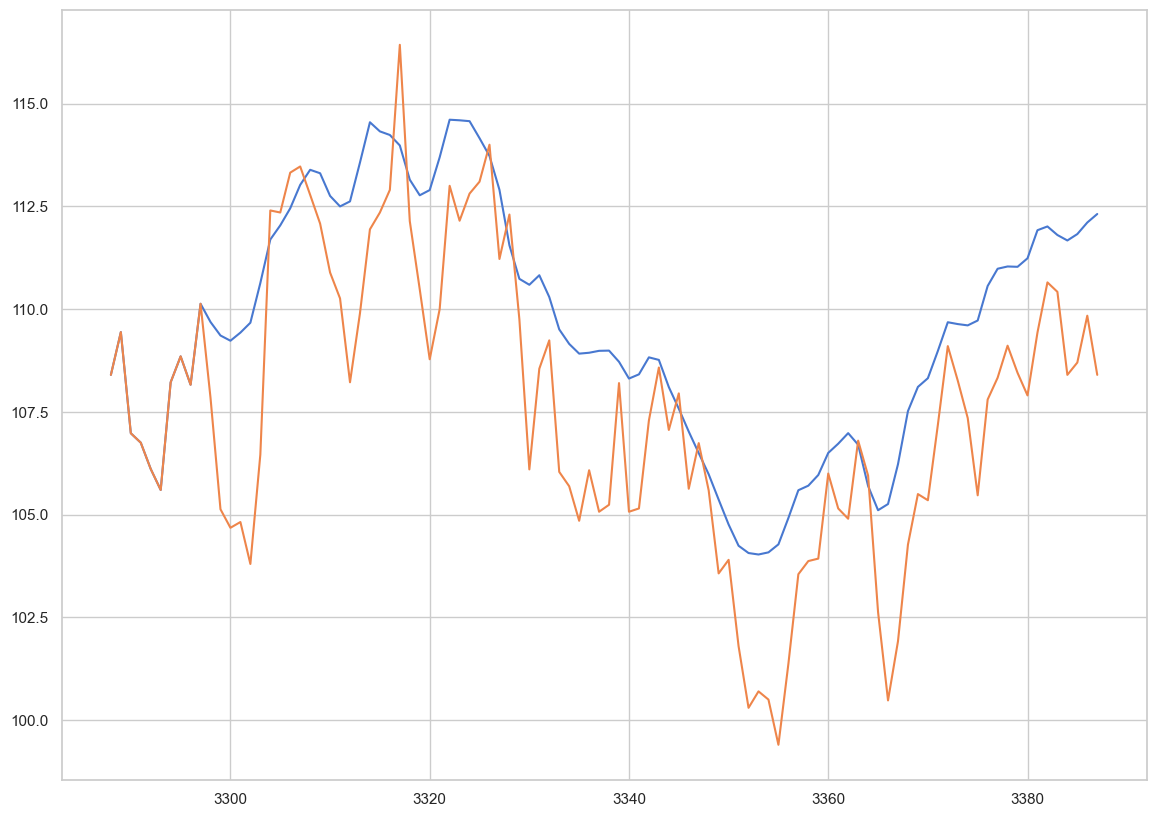

In [48]:
pred_90.close[-100:].plot()
bova11.close[-100:].plot()

<AxesSubplot:>

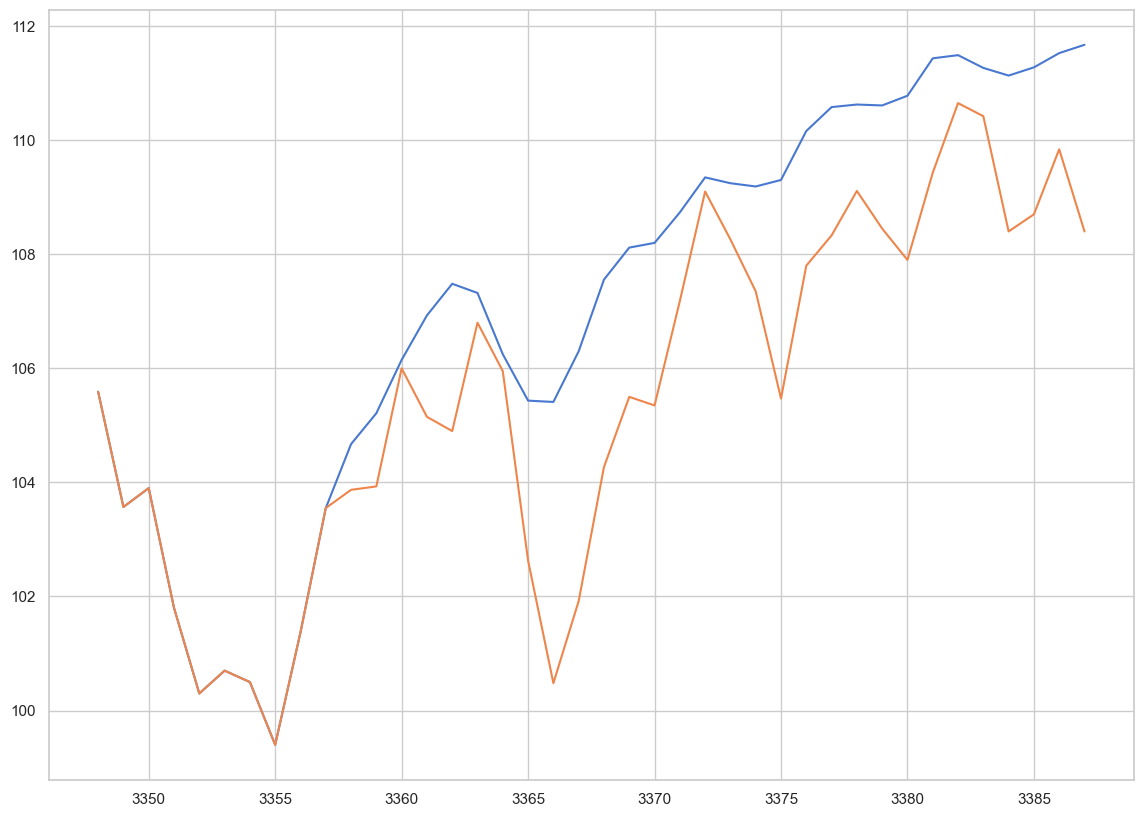

In [49]:
pred_30.close[-40:].plot()
bova11.close[-40:].plot()

<AxesSubplot:>

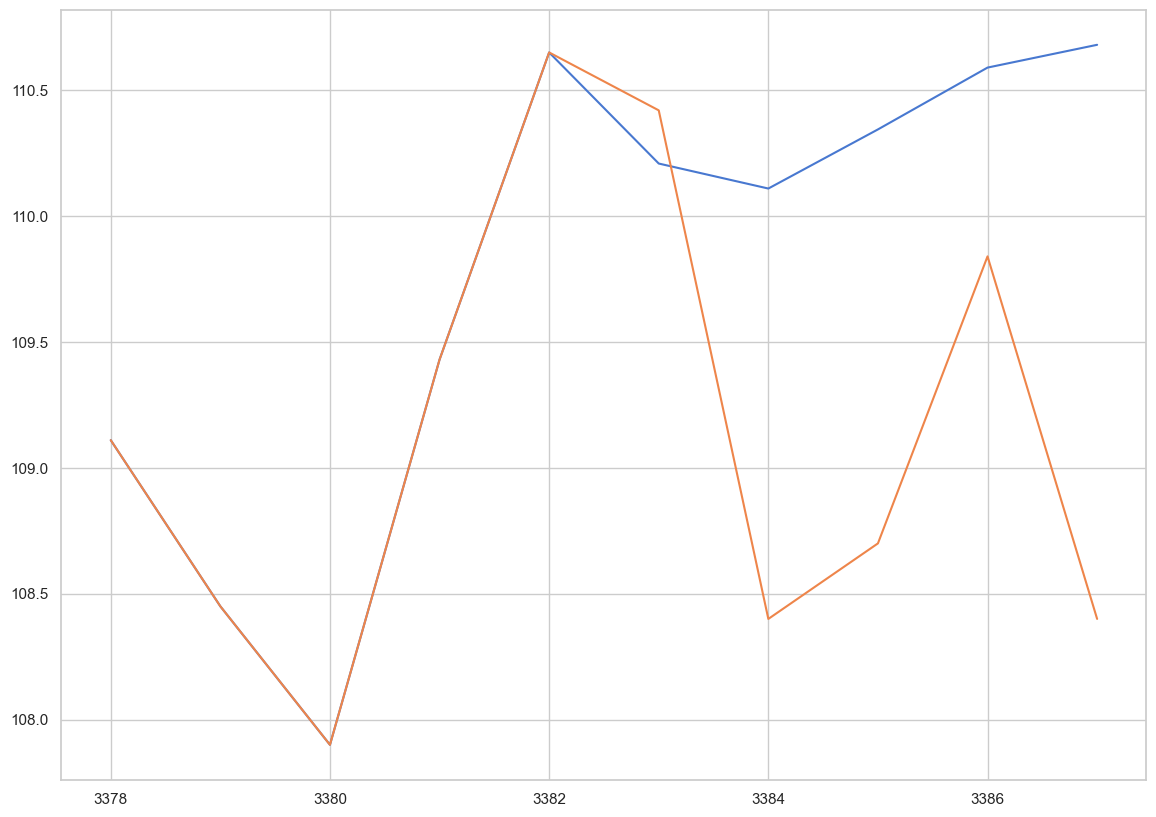

In [50]:
pred_5.close[-10:].plot()
bova11.close[-10:].plot()

<AxesSubplot:>

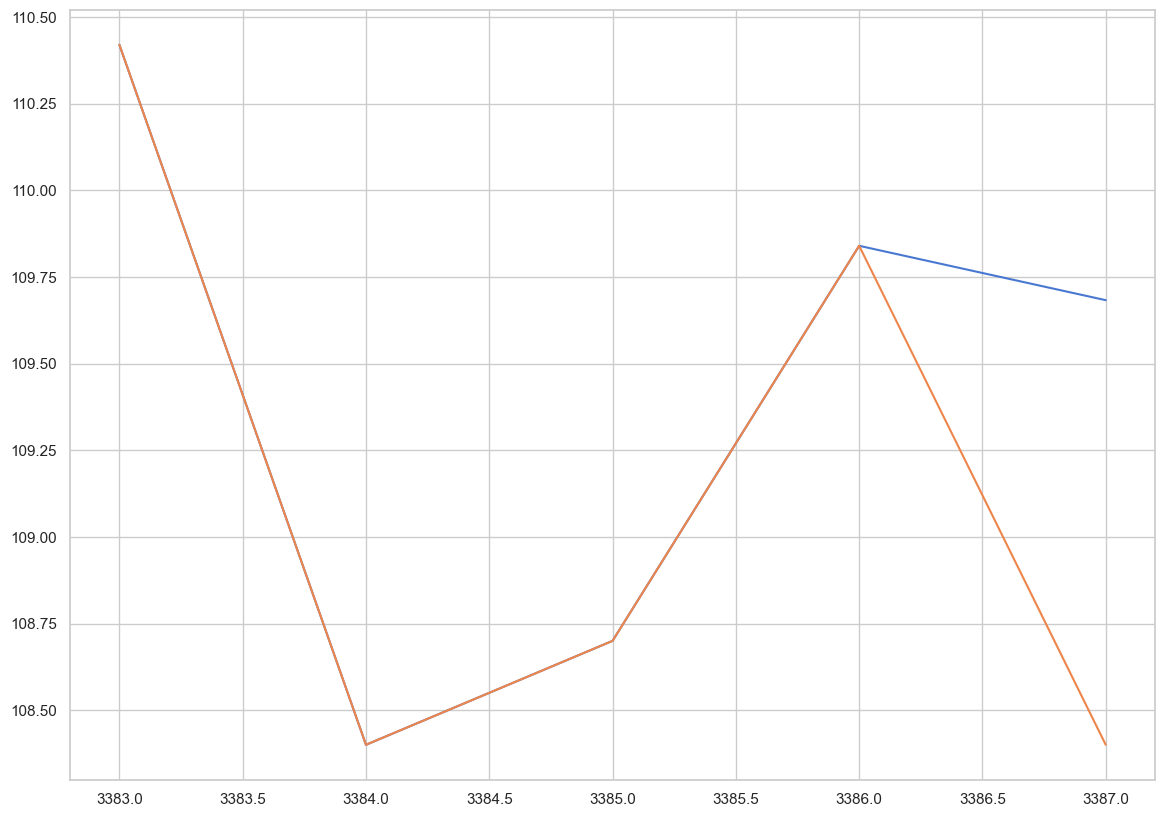

In [51]:
pred_1.close[-5:].plot()
bova11.close[-5:].plot()

In [53]:
bova11

,open,high,low,close,close_change,ma_3d,ma_10d,ma_30d,ma_60d,std_7,...,std_60,upper3,lower3,upper30,lower30,upper60,lower60,RSI,target,targetNextClose
0,37.009998,38.430000,36.799999,38.080002,-0.160000,38.440001,39.109001,40.216334,39.769778,0.918000,...,1.612324,39.423056,37.456947,43.005967,37.426700,42.994426,36.545130,37.055643,1.070004,39.000000
1,38.060001,39.500000,37.910000,39.000000,0.919998,38.690001,39.120000,40.267334,39.750870,0.944667,...,1.599458,39.746598,37.633404,43.120039,37.414628,42.949786,36.551954,44.613302,0.939999,38.990002
2,38.509998,38.990002,38.320000,38.990002,-0.009998,39.630001,39.125000,40.267000,39.731702,0.954819,...,1.587425,41.829729,37.430273,43.118870,37.415130,42.906553,36.556852,44.551016,0.480003,40.900002
3,39.369999,40.900002,39.369999,40.900002,1.910000,39.830001,39.226000,40.189667,39.726875,0.866391,...,1.570803,41.781103,37.878898,42.935008,37.444326,42.868481,36.585269,56.874437,1.530003,39.599998
4,39.740002,40.810001,39.369999,39.599998,-1.300003,40.033333,39.381001,40.168000,39.716123,0.700044,...,1.556176,41.534447,38.532219,42.908891,37.427110,42.828474,36.603771,48.942204,-0.140003,39.599998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3383,110.699997,111.099998,109.860001,110.419998,-0.230003,109.823334,109.130000,107.914762,105.926667,1.041406,...,3.095702,112.299324,107.347344,111.361764,104.467760,112.118071,99.735263,60.155206,-0.279999,108.400002
3384,110.279999,110.290001,108.339996,108.400002,-2.019997,109.173332,108.849000,108.097000,106.076000,0.938720,...,3.006460,111.353361,106.993303,111.190647,105.003353,112.088921,100.063079,53.755845,-1.879997,108.699997
3385,109.010002,109.320000,108.129997,108.699997,0.299995,108.979998,108.893333,108.233684,106.240000,1.501802,...,2.888394,110.499468,107.460529,111.153396,105.313973,112.016789,100.463212,54.525609,-0.310005,109.839996
3386,108.709999,109.959999,108.709999,109.839996,1.139999,108.979998,109.017500,108.393889,106.447273,1.427915,...,2.664053,110.499468,107.460529,111.032230,105.755548,111.775380,101.119166,57.411912,1.129997,108.400002


### Generating visualizations for the thesis

In [65]:
import plotly.express as px

In [84]:
import plotly.graph_objs as go
fig = go.Figure()

fig.add_trace(go.Scatter(
   y=bova11['close'],
   name="Fechamento")
)

fig.add_trace(go.Scatter(
   y=bova11['lower60'],
   name="Banda Inferior 60")
)

fig.add_trace(go.Scatter(
   y=bova11['upper60'],
   name="Banda Superior 60")
)

fig.update_layout(
   #title="Banda de Bollinger superior e inferior dos ultimos 60 dias de fechamento de 2009 a Fev 2023",
    yaxis_title="Valor de Fechamento",
    xaxis_title="periodo",
   #legend_title="legend",
)
fig.show()

In [85]:
bova11.columns

Index(['open', 'high', 'low', 'close', 'close_change', 'ma_3d', 'ma_10d',
       'ma_30d', 'ma_60d', 'std_7', 'std_30', 'std_60', 'upper3', 'lower3',
       'upper30', 'lower30', 'upper60', 'lower60', 'RSI', 'target',
       'targetNextClose'],
      dtype='object')

In [86]:
import plotly.graph_objs as go
fig = go.Figure()

fig.add_trace(go.Scatter(
   y=bova11['close'],
   name="Fechamento")
)

fig.add_trace(go.Scatter(
   y=bova11['ma_60d'],
   name="Média Móvel 60 dias")
)


fig.update_layout(
   #title="Banda de Bollinger superior e inferior dos ultimos 60 dias de fechamento de 2009 a Fev 2023",
    yaxis_title="Valor de Fechamento",
    xaxis_title="periodo",
   #legend_title="legend",
)
fig.show()

In [92]:
bova11_copy.tail(10)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
3487,2023-01-20 00:00:00-03:00,109.110001,109.150002,108.010002,108.449997,6287159,0,0
3488,2023-01-23 00:00:00-03:00,108.889999,109.330002,107.879997,107.900002,4401425,0,0
3489,2023-01-24 00:00:00-03:00,108.709999,109.430000,107.970001,109.430000,5724141,0,0
3490,2023-01-25 00:00:00-03:00,109.000000,110.680000,108.209999,110.650002,6427546,0,0
3491,2023-01-26 00:00:00-03:00,110.699997,111.099998,109.860001,110.419998,4382206,0,0
3492,2023-01-27 00:00:00-03:00,110.279999,110.290001,108.339996,108.400002,5294651,0,0
3493,2023-01-30 00:00:00-03:00,109.010002,109.320000,108.129997,108.699997,2905618,0,0
3494,2023-01-31 00:00:00-03:00,108.709999,109.959999,108.709999,109.839996,5733562,0,0
3495,2023-02-01 00:00:00-03:00,109.489998,109.860001,107.059998,108.400002,10380157,0,0
3496,2023-02-02 00:00:00-03:00,107.489998,109.269997,106.059998,106.300003,9555616,0,0


In [89]:
len(bova11)

3388

In [91]:
len(bova11_copy)

3497

In [93]:
import plotly.graph_objs as go
fig = go.Figure()

fig.add_trace(go.Scatter(
   y=bova11['close'],
   name="Fechamento")
)




fig.update_layout(
   #title="Banda de Bollinger superior e inferior dos ultimos 60 dias de fechamento de 2009 a Fev 2023",
    yaxis_title="Valor de Fechamento",
    xaxis_title="periodo",
   #legend_title="legend",
)
fig.show()

In [95]:
import plotly.graph_objs as go
fig = go.Figure()

fig.add_trace(go.Scatter(
   y=bova11['close_change'],
   name="Fechamento")
)




fig.update_layout(
   #title="Banda de Bollinger superior e inferior dos ultimos 60 dias de fechamento de 2009 a Fev 2023",
    yaxis_title="difença em relação ao fechamento anterior",
    xaxis_title="periodo",
   #legend_title="legend",
)
fig.show()